# Importing Packages and Loading Datasets

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, normalize, MaxAbsScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
''' data directories '''

datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'

In [3]:
seeds = pd.read_csv(os.path.join(datadir,'seeds.csv'), header=None)
fish = pd.read_csv(os.path.join(datadir,'fish.csv'), header= None, index_col=0)
cmp_move = pd.read_csv(os.path.join(datadir,'company-stock-movements-2010-2015-incl.csv'), index_col=0)
#euro16 = pd.read_csv(os.path.join(datadir,'eurovision-2016.csv'))

wiki = pd.read_csv(os.path.join(datadir,'wikipedia-vectors.csv'), index_col=0)
wiki_words = np.loadtxt(os.path.join(datadir,'wikipedia-vocabulary-utf8.txt'), dtype=str)

lcd_digits = pd.read_csv(os.path.join(datadir,'lcd-digits.csv'), header=None)

artists = pd.read_csv(os.path.join(datadir,'scrobbler-small-sample.csv'))
artist_names = np.loadtxt(os.path.join(datadir,'artists.csv'),dtype=str, delimiter='\n')

In [4]:
with open(os.path.join(datadir_pr,'points_cluster.npz'), 'rb') as f:
    ds    = np.load(f)
    points, new_points = ds['points'], ds['new_points']
    
with open(os.path.join(datadir_pr,'samples_grain.npz'), 'rb') as f:
    ds = np.load(f)
    samples, varieties = ds['samples'], ds['varieties']
    
euro16 = pd.read_csv(os.path.join(datadir_pr, 'eurovision2.csv'), index_col=0)

# Clustering for dataset exploration

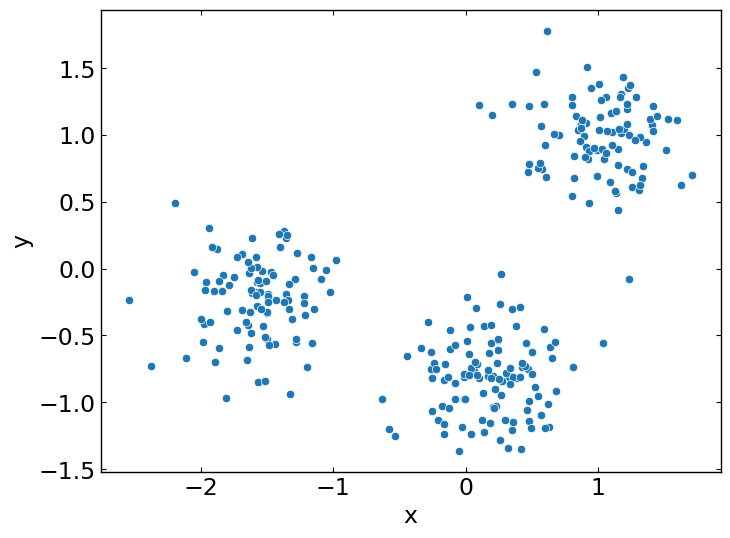

In [5]:
ax = sns.scatterplot(x=points[:,0], y=points[:,1])
ax.set_xlabel('x')
ax.set_ylabel('y');

> create a KMeans model to find 3 clusters, and fit it to the data points

In [6]:
# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=3)

# Fit model to points
model.fit(points)

# Determine the cluster labels of new_points: labels
labels = model.predict(new_points)

# Print cluster labels of new_points
print(labels)

[2 1 0 2 1 2 1 1 1 0 2 1 1 0 0 1 0 0 1 1 0 1 2 1 2 0 1 0 0 2 2 1 1 1 0 2 1
 1 2 1 0 2 2 0 2 1 0 0 1 1 1 1 0 0 2 2 0 0 0 2 2 1 1 1 2 1 0 1 2 0 2 2 2 1
 2 0 0 2 1 0 2 0 2 1 0 1 0 2 1 1 1 2 1 1 2 0 0 0 0 2 1 2 0 0 2 2 1 2 0 0 2
 0 0 0 1 1 1 1 0 0 1 2 1 0 1 2 0 1 0 0 1 0 1 0 2 1 2 2 1 0 2 1 2 2 0 1 1 2
 0 2 0 1 2 0 0 2 0 1 1 0 1 0 0 1 1 2 1 1 0 2 0 2 2 1 2 1 1 2 2 0 2 2 2 0 1
 1 2 0 2 0 0 1 1 1 2 1 1 1 0 0 2 1 2 2 2 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0
 1 1 2 0 2 2 0 2 0 2 0 1 1 0 1 1 1 0 2 2 0 1 1 0 1 0 0 1 0 0 2 0 2 2 2 1 0
 0 0 2 1 2 0 2 0 0 1 2 2 2 0 1 1 1 2 1 0 0 1 2 2 0 2 2 0 2 1 2 0 0 0 0 1 0
 0 1 1 2]


## Inspect the clustering

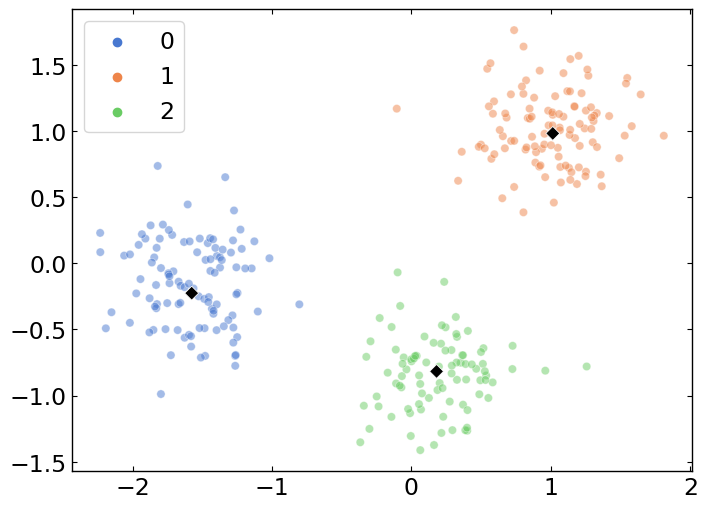

In [7]:
# Assign the columns of new_points: xs and ys
xs = new_points[:,0]
ys = new_points[:,1]

fig, ax = plt.subplots()
# Make a scatter plot of xs and ys, using labels to define the colors
sns.scatterplot(x=xs, y=ys, hue=labels, alpha=0.5, palette='muted', ax=ax)

# Assign the cluster centers: centroids
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

clr = ['k' for i in range(len(centroids_x))]  # color array
# Make a scatter plot of centroids_x and centroids_y
sns.scatterplot(x=centroids_x, y=centroids_y, marker='D', s=50, c=clr, ax=ax);

## Evaluating Clusters

What's a good number of clusters in this case?

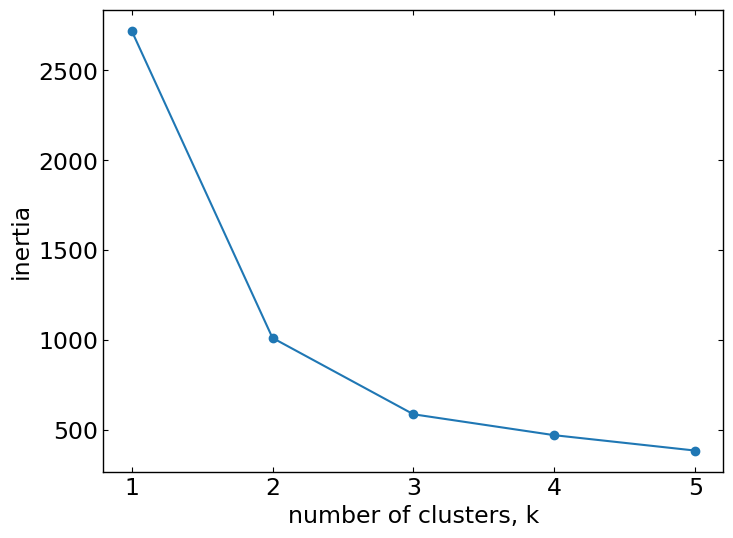

In [8]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(samples)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
fig, ax = plt.subplots()
# Plot ks vs inertias
ax.plot(ks, inertias, '-o')
ax.set_xlabel('number of clusters, k')
ax.set_ylabel('inertia');
#plt.xticks(ks)

the grain samples come from a mix of 3 different grain varieties: "Kama", "Rosa" and "Canadian". In this exercise, cluster the grain samples into three clusters, and compare the clusters to the grain varieties using a ***cross-tabulation.***

In [9]:
seeds.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [10]:
seeds.loc[seeds[7]==1, 'varieties'] = "Kama wheat"
seeds.loc[seeds[7]==2, 'varieties'] = "Rosa wheat"
seeds.loc[seeds[7]==3, 'varieties'] = "Canadian wheat"

seeds.rename(columns={7:'variety_numbers'}, inplace=True)
#seeds.drop(columns=[7], inplace=True)
seeds.head()

,0,1,2,3,4,5,6,variety_numbers,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat


In [11]:
samples_grain = seeds.drop(columns=['varieties','variety_numbers']).to_numpy()
varieties = seeds['varieties'].to_numpy()

print(np.shape(samples_grain))
print(np.shape(varieties))

(210, 7)
(210,)


In [12]:
# Create a KMeans model with 3 clusters: model
model = KMeans(n_clusters=3)

# Use fit_predict to fit model and obtain cluster labels: labels
labels = model.fit_predict(samples_grain)

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties})

# Create crosstab: ct
ct = pd.crosstab(df['labels'], df['varieties'])

# Display ct
print(ct)

varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                      68           9           0
1                       0           1          60
2                       2          60          10


## Scaling the data for clustering

In [13]:
fish.head()

,1,2,3,4,5,6
0,,,,,,
Bream,242.0,23.2,25.4,30.0,38.4,13.4
Bream,290.0,24.0,26.3,31.2,40.0,13.8
Bream,340.0,23.9,26.5,31.1,39.8,15.1
Bream,363.0,26.3,29.0,33.5,38.0,13.3
Bream,430.0,26.5,29.0,34.0,36.6,15.1


In [14]:
fish.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Bream to Pike
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       85 non-null     float64
 1   2       85 non-null     float64
 2   3       85 non-null     float64
 3   4       85 non-null     float64
 4   5       85 non-null     float64
 5   6       85 non-null     float64
dtypes: float64(6)
memory usage: 4.6+ KB


In [15]:
''' DataFrame to numpy array '''

samples_fish = fish.to_numpy()

species_fish = fish.index.to_numpy()
print(np.shape(samples_fish))
print(np.shape(species_fish))

(85, 6)
(85,)


In [16]:
# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

In [17]:
# Fit the pipeline to samples
pipeline.fit(samples_fish)

# Calculate the cluster labels: labels
labels = pipeline.predict(samples_fish)

# Create a DataFrame with labels and species as columns: df
df = pd.DataFrame({'labels':labels, 'species':species_fish})

# Create crosstab: ct
ct = pd.crosstab(df['labels'], df['species'])

# Display ct
print(ct)

species  Bream  Pike  Roach  Smelt
labels                            
0           33     0      1      0
1            0     0      0     13
2            0    17      0      0
3            1     0     19      1


you'll cluster companies using their daily stock price movements (i.e. the dollar difference between the closing and opening prices for each trading day). You are given dataset of daily price movements from 2010 to 2015 (obtained from Yahoo! Finance), where each row corresponds to a company, and each column corresponds to a trading day.

In [18]:
cmp_move.head()

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,-0.709999,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998


In [19]:
''' to numpy array '''

movements = cmp_move.to_numpy()
companies = cmp_move.index.to_numpy()

print(np.shape(movements))
print(np.shape(companies))

(60, 963)
(60,)


In [20]:
# Create a normalizer: normalizer
normalizer = Normalizer()

# Create a KMeans model with 10 clusters: kmeans
kmeans = KMeans(n_clusters=10)

# Make a pipeline chaining normalizer and kmeans: pipeline
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to the daily price movements
pipeline.fit(movements)

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=10))])

In [21]:
# Predict the cluster labels: labels
labels = pipeline.predict(movements)

# Create a DataFrame aligning labels and companies: df
df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster label
print(df.sort_values(by='labels'))

    labels                           companies
32       0                                  3M
35       0                            Navistar
8        0                         Caterpillar
13       0                   DuPont de Nemours
25       1                   Johnson & Johnson
19       1                     GlaxoSmithKline
39       1                              Pfizer
30       2                          MasterCard
45       2                                Sony
48       2                              Toyota
21       2                               Honda
20       2                          Home Depot
34       2                          Mitsubishi
59       2                               Yahoo
7        2                               Canon
38       3                               Pepsi
41       3                       Philip Morris
28       3                           Coca Cola
9        3                   Colgate-Palmolive
27       3                      Kimberly-Clark
40       3   

# Visualization with Hierarchical Clustering and t-SNE

### Back to grain (seeds) case

In [22]:
print(np.shape(samples_grain))

# reduce size for practice
samples_gr_reduced = samples_grain[1::5]
varieties_reduced  = varieties[1::5]
print(np.shape(samples_gr_reduced))

(210, 7)
(42, 7)


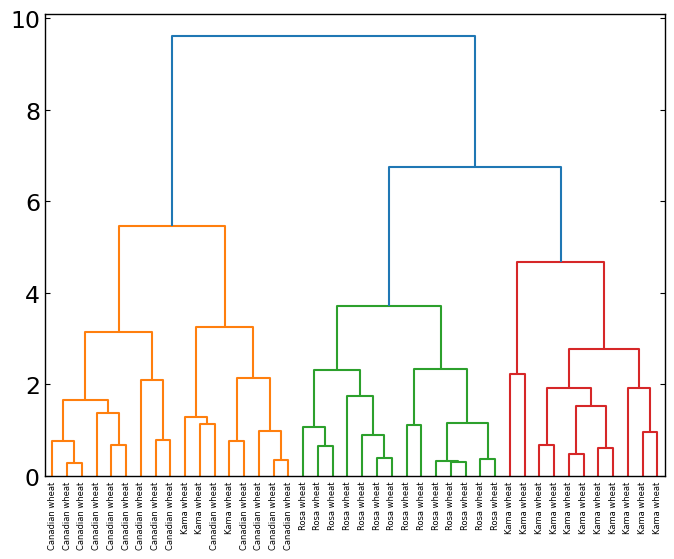

In [23]:
# Calculate the linkage: mergings
mergings = linkage(samples_gr_reduced, method='complete')

# Plot the dendrogram, using varieties as labels
dendrogram(mergings, labels=varieties_reduced, leaf_rotation=90, leaf_font_size=6);

### Hierarchies of stocks: clustering of compnaies

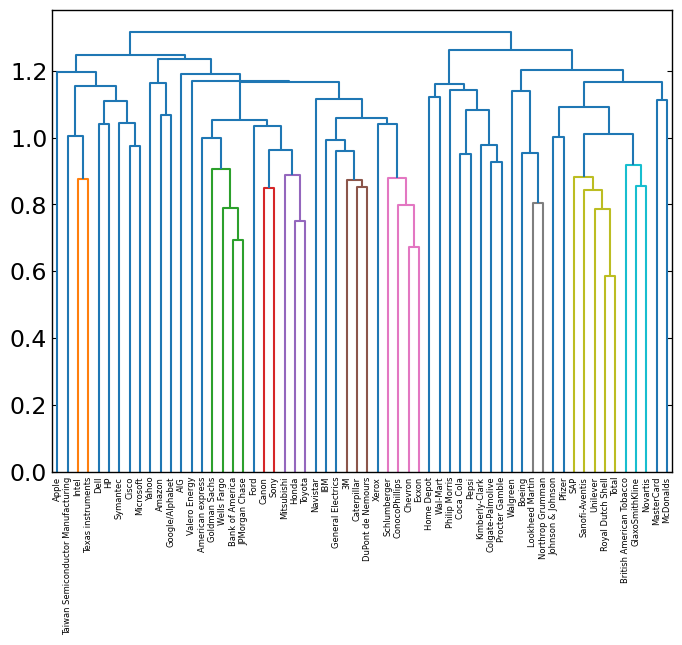

In [24]:
# Normalize the movements: normalized_movements
normalized_movements = normalize(movements)

# Calculate the linkage: mergings
mergings = linkage(normalized_movements, method='complete')

# Plot the dendrogram
dendrogram(mergings, labels=companies, leaf_rotation=90, leaf_font_size=6);

In [25]:
print(np.shape(companies))

(60,)


## different linkage: complete, single

In [26]:
euro16.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
Albania,2.0,12.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,4.0,0.0,5.0,7.0,0.0,0.0,3.0,0.0,6.0,0.0
Armenia,12.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,...,0.0,5.0,1.0,12.0,0.0,0.0,2.0,0.0,10.0,0.0
Australia,0.0,12.0,3.0,0.0,12.0,10.0,0.0,0.0,0.0,7.0,...,1.0,6.0,0.0,5.0,0.0,2.0,0.0,0.0,8.0,4.0
Austria,0.0,3.0,12.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,...,0.0,0.0,12.0,8.0,4.0,0.0,7.0,6.0,10.0,0.0
Azerbaijan,0.0,2.0,0.0,12.0,0.0,8.0,0.0,0.0,0.0,4.0,...,0.0,5.0,3.0,12.0,0.0,0.0,0.0,0.0,10.0,0.0


In [27]:
samples_euro = euro16.to_numpy()
country_names = euro16.index

print(np.shape(samples_euro))

(42, 26)


In [28]:
print(country_names)

Index(['Albania', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Belarus',
       'Belgium', 'Bosnia & Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'F.Y.R. Macedonia', 'Finland',
       'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Israel', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Moldova',
       'Montenegro', 'Norway', 'Poland', 'Russia', 'San Marino', 'Serbia',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'The Netherlands',
       'Ukraine', 'United Kingdom'],
      dtype='object')


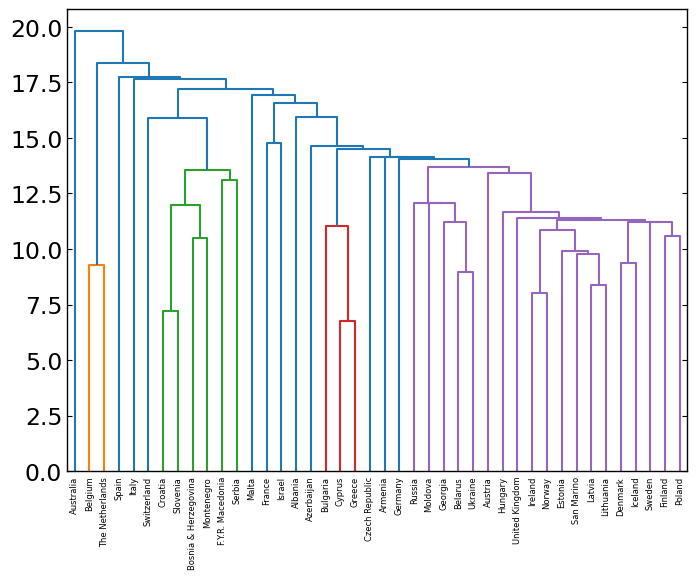

In [29]:
# Calculate the linkage: mergings
mergings = linkage(samples_euro, method='single')  # Now the method is set to single

# Plot the dendrogram
dendrogram(mergings, labels=country_names, leaf_rotation=90, leaf_font_size=6);

## Extracting the cluster labels for the intermediate clustering 

With Grain example, we would use the `fcluster()` function to extract the cluster labels for this intermediate clustering, and compare the labels with the grain varieties using a `cross-tabulation`.

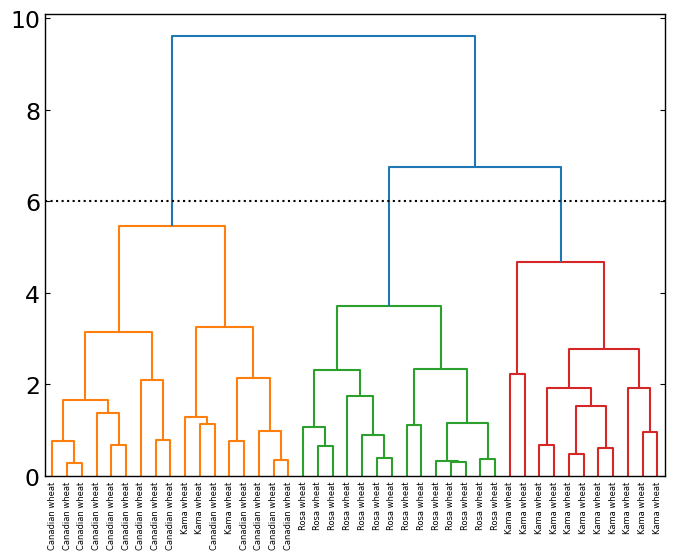

In [30]:
""" Draw dendrogram again """
# Calculate the linkage: mergings
mergings = linkage(samples_gr_reduced, method='complete')

fig, ax = plt.subplots()
# Plot the dendrogram, using varieties as labels
dendrogram(mergings, labels=varieties_reduced, leaf_rotation=90, leaf_font_size=6, ax=ax)

tr_height = 6 # height of the tree
ax.axhline(y=tr_height, color='k', linestyle=':');

In [31]:
# Use fcluster to extract labels: labels
labels = fcluster(mergings, tr_height, criterion='distance')

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'labels': labels, 'varieties': varieties_reduced})

# Create crosstab: ct
ct = pd.crosstab(df['labels'],df['varieties'])

# Display ct
print(ct)

varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
1                      14           3           0
2                       0           0          14
3                       0          11           0


## t-SNE for 2-D maps

In [32]:
seeds.head()

,0,1,2,3,4,5,6,variety_numbers,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat


In [33]:
variety_numbers = seeds['variety_numbers'].to_numpy()

print(np.shape(samples_grain))
print(len(variety_numbers))

(210, 7)
210


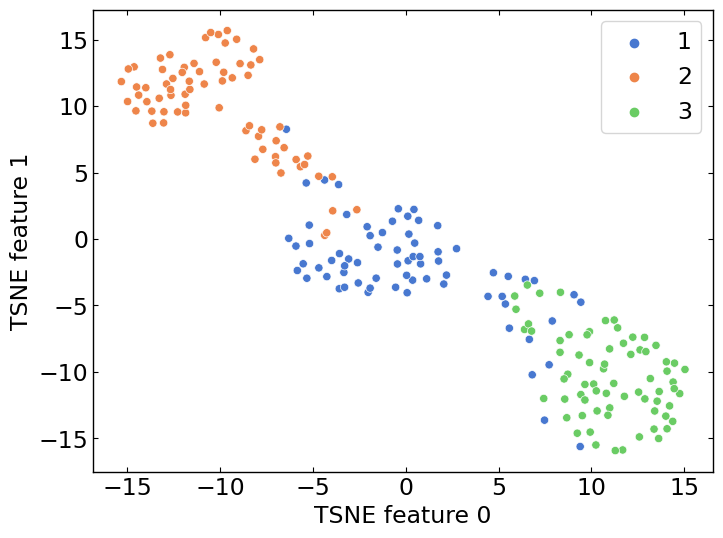

In [34]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=200, init='random')

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(samples_grain)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
ax = sns.scatterplot(x=xs, y=ys, hue=variety_numbers, palette='muted')
ax.set_xlabel('TSNE feature 0')
ax.set_ylabel('TSNE feature 1');

`t-SNE` provides great visualizations when the individual samples can be labeled. In this exercise, you'll apply `t-SNE` to the company stock price data. A scatter plot of the resulting `t-SNE` features, labeled by the company names, gives you a map of the stock market!

In [35]:
print(np.shape(normalized_movements))

(60, 963)


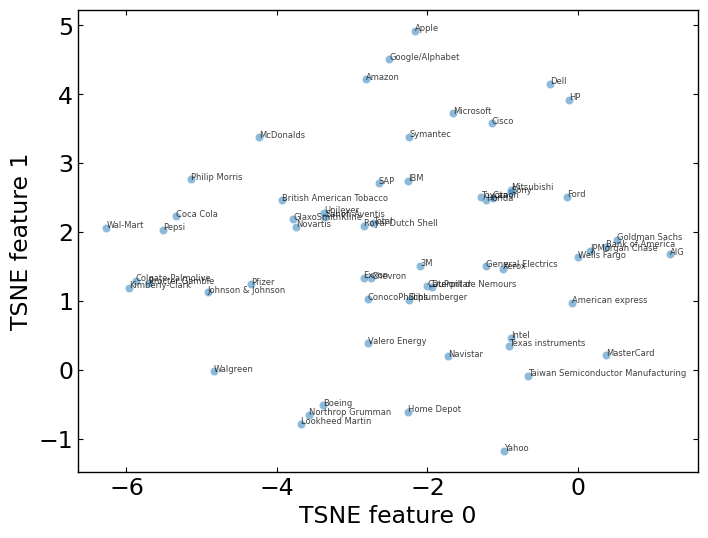

In [36]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=50, init='random')

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalized_movements)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

# Scatter plot
ax = sns.scatterplot(x=xs, y=ys, alpha=0.5)

# Annotate the points
for x, y, company in zip(xs, ys, companies):
    ax.annotate(company, (x, y), fontsize=6, alpha=0.75)
    
ax.set_xlabel('TSNE feature 0')
ax.set_ylabel('TSNE feature 1');

# Decorrelating your data and Dimension Reduction

## Visualizing the PCA tansfromation

In [37]:
seeds.head()

,0,1,2,3,4,5,6,variety_numbers,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat


In [38]:
grains = seeds.loc[:,[4,3]].to_numpy()

> suspect that width and length will be correlated. To confirm this, make a scatter plot of width vs length and measure their Pearson correlation.

Pearson-r value: 0.8604149377143469


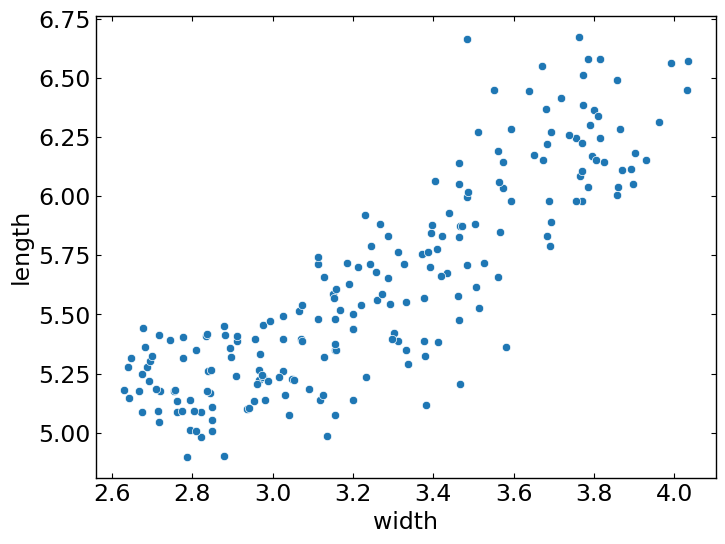

In [39]:
# Assign the 0th column of grains: width
width = grains[:,0]

# Assign the 1st column of grains: length
length = grains[:,1]

# Calculate the Pearson correlation
correlation, pvalue = pearsonr(width,length)

# Display the correlation
print("Pearson-r value: {}".format(correlation))

# Scatter plot width vs length
ax = sns.scatterplot(x=width, y=length)
ax.set_xlabel('width')
ax.set_ylabel('length');

## Decorrelating the measurements with PCA

You observed in the previous exercise that the width and length measurements of the grain are correlated. Now, you'll use PCA to decorrelate these measurements, then plot the decorrelated points and measure their Pearson correlation.

Pearson-r value after Decorrelation: -4.163336342344337e-17


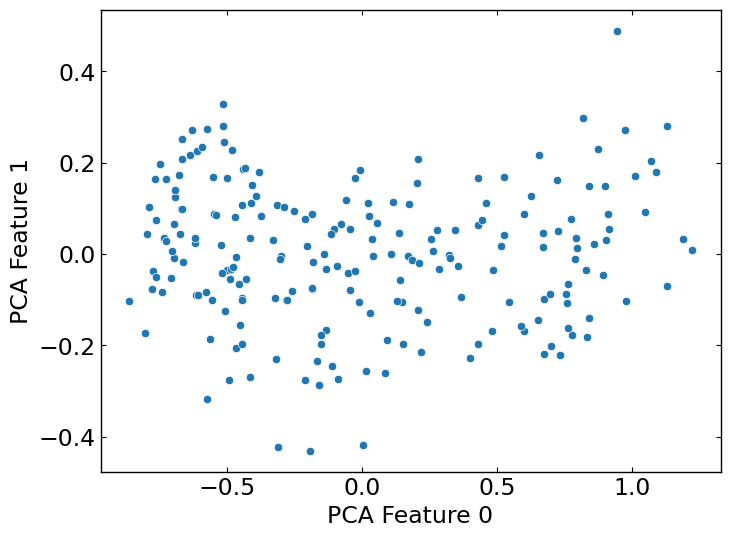

In [40]:
# Create PCA instance: model
model = PCA()

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(grains)

# Assign 0th column of pca_features: xs
xs = pca_features[:,0]

# Assign 1st column of pca_features: ys
ys = pca_features[:,1]

# Calculate the Pearson correlation of xs and ys
correlation, pvalue = pearsonr(xs, ys)

# Display the correlation
print("Pearson-r value after Decorrelation: {}".format(correlation))

# Scatter plot xs vs ys
ax=sns.scatterplot(x=xs, y=ys)
ax.set_xlabel('PCA Feature 0')
ax.set_ylabel('PCA Feature 1');

## Intrinsic Dimension

**The first principal component of the data is the direction in which the data varies the most.**

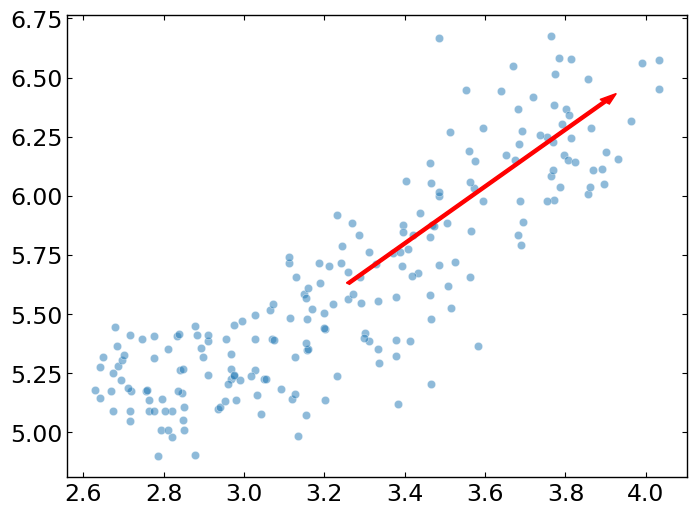

In [41]:
# Make a scatter plot of the untransformed points
ax = sns.scatterplot(x=grains[:,0], y=grains[:,1], alpha=0.5)

# Create a PCA instance: model
model = PCA()

# Fit model to points
model.fit(grains)

# Get the mean of the grain samples: mean
mean = model.mean_

# Get the first principal component: first_pc
first_pc = model.components_[0,:]
#second_pc = model.components_[1,:]

# Plot first_pc as an arrow, starting at mean
ax.arrow(mean[0], mean[1], first_pc[0], first_pc[1], color='red', width=0.01);
#ax.arrow(mean[0], mean[1], second_pc[0], second_pc[1], color='red', width=0.01)

## Variance of the PCA features

The fish dataset is 6-dimensional. But what is its intrinsic dimension? Make a plot of the variances of the PCA features to find out. 

In [42]:
fish.head()

,1,2,3,4,5,6
0,,,,,,
Bream,242.0,23.2,25.4,30.0,38.4,13.4
Bream,290.0,24.0,26.3,31.2,40.0,13.8
Bream,340.0,23.9,26.5,31.1,39.8,15.1
Bream,363.0,26.3,29.0,33.5,38.0,13.3
Bream,430.0,26.5,29.0,34.0,36.6,15.1


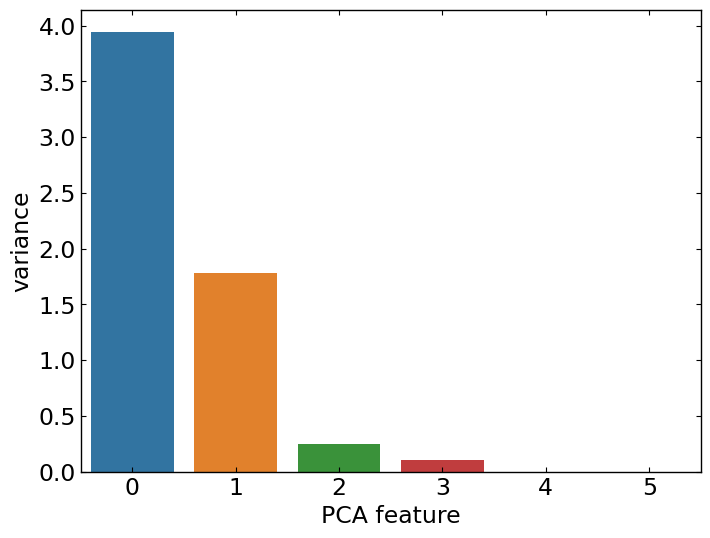

In [43]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(samples_fish)

# Plot the explained variances
df_feature = pd.DataFrame(pca.explained_variance_).T
ax = sns.barplot(data=df_feature)
ax.set_xlabel('PCA feature')
ax.set_ylabel('variance');

#features = range(pca.n_components_)
#plt.bar(features, pca.explained_variance_)
#plt.xlabel('PCA feature')
#plt.ylabel('variance')
#plt.xticks(features);

> The reasonable choice of the intrinsic dimension would be 2 here.

## Dimension Reduction w/ PCA

Now use PCA for dimensionality reduction of the fish measurements, retaining only the 2 (apparent intrinsic dimension) most important components.

In [44]:
# scale the fish data
scale = StandardScaler()
scaled_samples_fish = scale.fit_transform(samples_fish)
#print(scaled_samples_fish)

# Create a PCA model with 2 components: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the scaled samples
pca.fit(scaled_samples_fish)

# Transform the scaled samples: pca_features
pca_features = pca.transform(scaled_samples_fish)

# Print the shape of pca_features
print("shape of the PCA features: {}".format(pca_features.shape))

shape of the PCA features: (85, 2)


### tf-idf word-frequency array

- a tf-idf word frequency array for a toy collection of documents.
- It transforms a list of documents into a word frequency array.
- `fit()` and `transform()` methods like other sklearn objects.

In [45]:
''' Data article '''
documents = ['cats say meow', 'dogs say woof', 'dogs chase cats']

In [46]:
# Create a TfidfVectorizer: tfidf
tfidf = TfidfVectorizer()

# Apply fit_transform to document: csr_mat
csr_mat = tfidf.fit_transform(documents)

# Print result of toarray() method
print(csr_mat.toarray())

# Get the words: words
words = tfidf.get_feature_names_out()  # .get_feature_names() method is deprecated and replaced by .get_feature_names_out()

# Print words
print(words)

[[0.51785612 0.         0.         0.68091856 0.51785612 0.        ]
 [0.         0.         0.51785612 0.         0.51785612 0.68091856]
 [0.51785612 0.68091856 0.51785612 0.         0.         0.        ]]
['cats' 'chase' 'dogs' 'meow' 'say' 'woof']


In [47]:
print(csr_mat)

  (0, 3)	0.680918560398684
  (0, 4)	0.5178561161676974
  (0, 0)	0.5178561161676974
  (1, 5)	0.680918560398684
  (1, 2)	0.5178561161676974
  (1, 4)	0.5178561161676974
  (2, 1)	0.680918560398684
  (2, 2)	0.5178561161676974
  (2, 0)	0.5178561161676974


### Clustering Wikipedia

- `TruncatedSVD` is able to perform `PCA` on sparse arrays in `csr_matrix` format, such as word-frequency arrays.

In [48]:
""" Convert the artilce data to csr_matrix (sparse array) """
articles_csr = csr_matrix(wiki.transpose())
titles_wiki  = list(wiki.columns)

In [49]:
# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=50)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=6)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd, kmeans)

# Fit the pipeline to articles
pipeline.fit(articles_csr)

# Calculate the cluster labels: labels
labels = pipeline.predict(articles_csr)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': titles_wiki})

# Display df sorted by cluster label
print(df.sort_values(by='label'))

    label                                        article
29      0                               Jennifer Aniston
28      0                                  Anne Hathaway
27      0                                 Dakota Fanning
26      0                                     Mila Kunis
25      0                                  Russell Crowe
24      0                                   Jessica Biel
23      0                           Catherine Zeta-Jones
22      0                              Denzel Washington
21      0                             Michael Fassbender
20      0                                 Angelina Jolie
0       1                                       HTTP 404
5       1                                         Tumblr
1       1                                 Alexa Internet
2       1                              Internet Explorer
3       1                                    HTTP cookie
4       1                                  Google Search
6       1                    Hy

# Discovering Interpretable Features

## Non-Negative Matrix Factorization (NMF)

In [50]:
# Create an NMF instance: model
model = NMF(n_components=6)

# Fit the model to articles
model.fit(articles_csr)

# Transform the articles: nmf_features
nmf_features = model.transform(articles_csr)

print("shapes of article features: {}".format(np.shape(articles_csr)))
print("shapes of NMF features: {}".format(np.shape(nmf_features)))
# Print the NMF features
print(nmf_features.round(2))

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


shapes of article features: (60, 13125)
shapes of NMF features: (60, 6)
[[0.   0.   0.   0.   0.   0.44]
 [0.   0.   0.   0.   0.   0.57]
 [0.   0.   0.   0.   0.   0.4 ]
 [0.   0.   0.   0.   0.   0.38]
 [0.   0.   0.   0.   0.   0.49]
 [0.01 0.01 0.01 0.03 0.   0.33]
 [0.   0.   0.02 0.   0.01 0.36]
 [0.   0.   0.   0.   0.   0.49]
 [0.02 0.01 0.   0.02 0.03 0.48]
 [0.01 0.03 0.03 0.07 0.02 0.34]
 [0.   0.   0.53 0.   0.03 0.  ]
 [0.   0.   0.36 0.   0.   0.  ]
 [0.01 0.01 0.31 0.06 0.01 0.02]
 [0.   0.01 0.34 0.01 0.   0.  ]
 [0.   0.   0.43 0.   0.04 0.  ]
 [0.   0.   0.48 0.   0.   0.  ]
 [0.01 0.02 0.38 0.03 0.   0.01]
 [0.   0.   0.48 0.   0.   0.  ]
 [0.   0.01 0.55 0.   0.   0.  ]
 [0.   0.   0.47 0.   0.   0.  ]
 [0.   0.01 0.02 0.52 0.06 0.01]
 [0.   0.   0.   0.51 0.   0.  ]
 [0.   0.01 0.   0.42 0.   0.  ]
 [0.   0.   0.   0.44 0.   0.  ]
 [0.   0.   0.   0.5  0.   0.  ]
 [0.1  0.09 0.   0.38 0.   0.01]
 [0.   0.   0.   0.57 0.   0.01]
 [0.01 0.01 0.   0.47 0.   0.01]
 [0.

In [51]:
# Create a pandas DataFrame: df
df = pd.DataFrame(nmf_features, index=titles_wiki)

# Print the row for 'Anne Hathaway'
print(df.loc[df.index=='Anne Hathaway'])

# Print the row for 'Denzel Washington'
print(df.loc[df.index=='Denzel Washington'])

                      0    1    2         3    4    5
Anne Hathaway  0.003846  0.0  0.0  0.575593  0.0  0.0
                     0         1    2         3    4    5
Denzel Washington  0.0  0.005602  0.0  0.422293  0.0  0.0


## NMF reconstructs samples

- when NMF is applied to documents, the components correspond to topics of documents, and the NMF features reconstruct the documents from the topics. 

In [52]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=wiki_words)

# Print the shape of the DataFrame
print(components_df.shape)

# Select row 3: component
# 3rd NMF feature value was high for the articles about actors Anne Hathaway and Denzel Washington
component = components_df.iloc[3]

# Print result of nlargest
print(component.nlargest())

(6, 13125)
film       0.628005
award      0.253183
starred    0.245334
role       0.211494
actress    0.186436
Name: 3, dtype: float64


## Explore the LED digits dataset

In [53]:
lcd_digits.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
samples_led = lcd_digits.to_numpy()
print(np.shape(samples_led))

(100, 104)


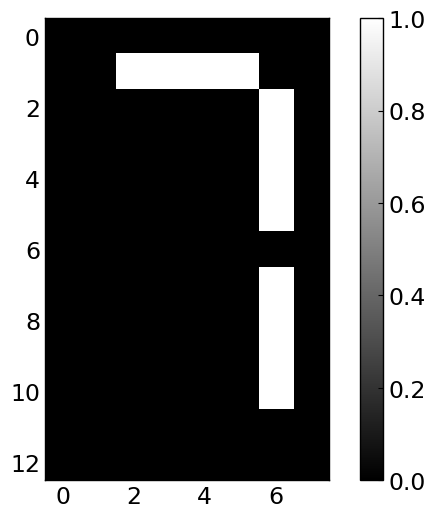

In [55]:
# Select the 0th row: digit
digit = samples_led[0]

# Print digit
#print(digit)

# Reshape digit to a 13x8 array: bitmap
bitmap = digit.reshape((13,8))

# Print bitmap
#print(bitmap)

# Use plt.imshow to display bitmap
fig, ax = plt.subplots()
im = ax.imshow(bitmap, cmap='gray', interpolation='nearest')
fig.colorbar(im);

### NMF learns the parts of images

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


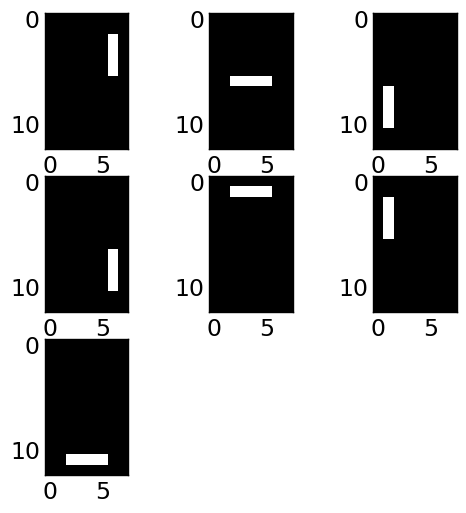

In [56]:
# Create an NMF model: model
model = NMF(n_components=7)

# Apply fit_transform to samples: features
features = model.fit_transform(samples_led)

n_fig = np.shape(model.components_)[0]
n_col = 3
fig, axes = plt.subplots(int(np.ceil(n_fig/n_col)), n_col, figsize=(6,6))

#remove redundant axis 
for ax in axes.flat[n_fig:]: 
    ax.remove()

# Call show_as_image on each component
for ax, component in zip(axes.flat, model.components_):
    bitmap = component.reshape(13,8)
    im = ax.imshow(bitmap, cmap='gray', interpolation='nearest')
    #fig.colorbar(im)

## PCA doesn't learn parts
- Unlike NMF, PCA doesn't learn the parts of things. Its components do not correspond to topics (in the case of documents) or to parts of images, when trained on images. 

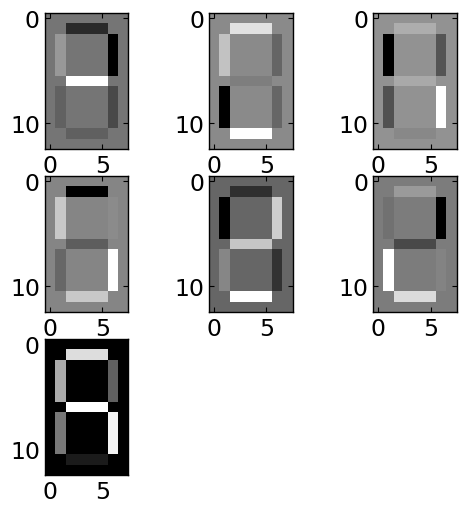

In [57]:
# Create a PCA instance: model
model = PCA(n_components=7)

# Apply fit_transform to samples: features
features = model.fit_transform(samples_led)

# Call show_as_image on each component
n_fig = np.shape(model.components_)[0]
n_col = 3
fig, axes = plt.subplots(int(np.ceil(n_fig/n_col)), n_col, figsize=(6,6))

#remove redundant axis 
for ax in axes.flat[n_fig:]: 
    ax.remove()

for ax, component in zip(axes.flat, model.components_):
    bitmap = component.reshape(13,8)
    im = ax.imshow(bitmap, cmap='gray', interpolation='nearest')
    #fig.colorbar(im)

## Building Recommender Systems using NMF
- the ***cosine similarity*** to find similar articles.
- e.g., NMF model for popular Wikipedia articles, by finding the articles most similar to the article about the footballer Cristiano Ronaldo. 

In [58]:
# Create an NMF instance: model
model = NMF(n_components=6)

# Fit the model to articles
model.fit(articles_csr)

# Transform the articles: nmf_features
nmf_features = model.transform(articles_csr)

print("shapes of article features: {}".format(np.shape(articles_csr)))
print("shapes of NMF features: {}".format(np.shape(nmf_features)))

shapes of article features: (60, 13125)
shapes of NMF features: (60, 6)


/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [59]:
# Normalize the NMF features: norm_features
norm_features = normalize(nmf_features)

# Create a DataFrame: df
df = pd.DataFrame(norm_features, index=titles_wiki)

# Select the row corresponding to 'Cristiano Ronaldo': article
article = df.loc['Cristiano Ronaldo']

# Compute the dot products: similarities
similarities = df.dot(article)

# Display those with the largest cosine similarity
print(similarities.nlargest())

Cristiano Ronaldo                1.000000
Franck Ribéry                    0.999972
Radamel Falcao                   0.999942
Zlatan Ibrahimović               0.999942
France national football team    0.999923
dtype: float64


### Recommend musical artists 

- we'll use `NMF` to recommend popular music artists! You are given a sparse array `samples_artists` whose rows correspond to artists and whose columns correspond to users. The entries give the number of times each artist was listened to by each user.
- `MaxAbsScaler`, transforms the data so thatall users have the same influence on the model, regardless of how many different artists they've listened to. In the next exercise, you'll use the resulting normalized `NMF` features for recommendation!

In [60]:
artists.head()

,user_offset,artist_offset,playcount
0,1,79,58
1,1,84,80
2,1,86,317
3,1,89,64
4,1,96,159


In [61]:
""" generate matrix from dataset that has indices and values  """ 

ind_arr = artists.loc[:,['user_offset','artist_offset']].to_numpy()
val_arr = artists.playcount.to_numpy()
print(np.shape(ind_arr), np.shape(val_arr))

samples_artists = np.zeros((artists.artist_offset.max()+1, artists.user_offset.max()+1))
print(np.shape(samples_artists))

for i in range(len(val_arr)):
    samples_artists[ind_arr[i,1], ind_arr[i,0]] = val_arr[i]

(2894, 2) (2894,)
(111, 500)


In [62]:
# Create a MaxAbsScaler: scaler
scaler = MaxAbsScaler()

# Create an NMF model: nmf
nmf = NMF(n_components=20)

# Create a Normalizer: normalizer
normalizer = Normalizer()

# Create a pipeline: pipeline
pipeline = make_pipeline(scaler, nmf, normalizer)

# Apply fit_transform to artists: norm_features
norm_features = pipeline.fit_transform(samples_artists)

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [63]:
# Create a DataFrame: df
df = pd.DataFrame(norm_features, index=artist_names)

# Select row of 'Bruce Springsteen': artist
artist = df.loc['Bruce Springsteen']

# Compute cosine similarities: similarities
similarities = df.dot(artist)

# Display those with highest cosine similarity
print(similarities.nlargest())

Bruce Springsteen    1.000000
Neil Young           0.957455
Van Morrison         0.876210
Leonard Cohen        0.867410
Bob Dylan            0.864184
dtype: float64


# Data copy and re-generate from DataCamp